Task 1

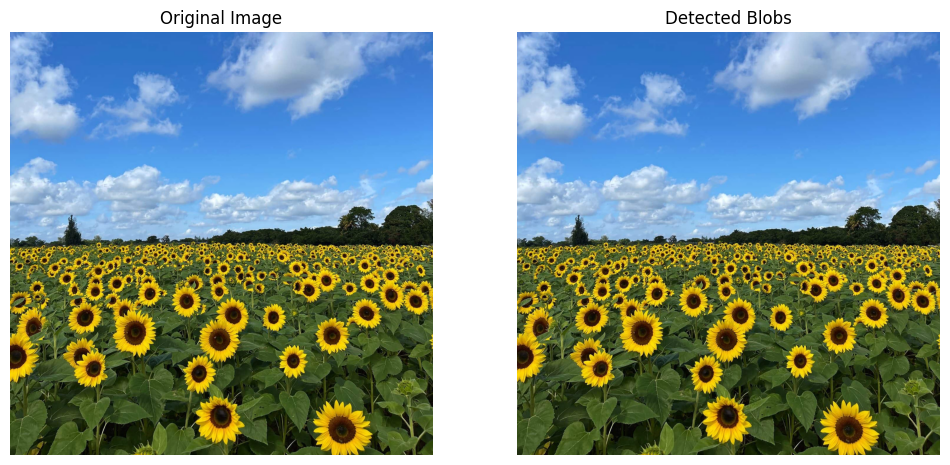

Detected blobs (x, y, sigma):

Sigma values range: 2 to 15


In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_laplace

# Load and preprocess the image
image = cv2.imread(r'Img\the_berry_farms_sunflower_field.jpeg', cv2.IMREAD_COLOR)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Function for blob detection using Laplacian of Gaussian (LoG) and scale-space extrema detection
def log_scale_space_detection(image, min_sigma, max_sigma, num_scales, threshold):
    blobs = []
    sigma_values = np.linspace(min_sigma, max_sigma, num_scales)
    laplacian_scales = []
    
    # Loop through each scale (sigma value)
    for sigma in sigma_values:
        # Apply Gaussian blur and then Laplacian (LoG)
        log_response = gaussian_laplace(image, sigma=sigma)
        # Square the response to get rid of negative values
        log_response = np.square(log_response)
        laplacian_scales.append(log_response)
    
    # Stack all the Laplacian results from different scales into a 3D array
    laplacian_stack = np.stack(laplacian_scales, axis=-1)
    
    # Detect local maxima in both space and scale
    for i in range(1, laplacian_stack.shape[0] - 1):
        for j in range(1, laplacian_stack.shape[1] - 1):
            for k in range(1, num_scales - 1):
                if laplacian_stack[i, j, k] > threshold:
                    # Check if this pixel is a local maximum in 3D scale-space
                    if (laplacian_stack[i, j, k] > laplacian_stack[i - 1:i + 2, j - 1:j + 2, k - 1:k + 2].max()):
                        blobs.append((i, j, sigma_values[k]))
    
    return blobs

# Parameters
min_sigma = 2      # Minimum scale (smallest blobs)
max_sigma = 15     # Maximum scale (largest blobs)
num_scales = 15    # Number of scales to search over
threshold = 0.03   # Threshold to ignore weak blobs

# Apply the LoG-based scale-space blob detection
blobs = log_scale_space_detection(gray, min_sigma, max_sigma, num_scales, threshold)

# Draw circles on the detected blobs
output_image = image.copy()
for blob in blobs:
    y, x, sigma = blob
    r = int(sigma * np.sqrt(2))
    cv2.circle(output_image, (x, y), r, (0, 255, 0), 2)

# Convert BGR to RGB for displaying
output_image_rgb = cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB)

# Display original and blob-detected image
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(output_image_rgb)
plt.title('Detected Blobs')
plt.axis('off')

plt.show()

# Print detected blob parameters
print("Detected blobs (x, y, sigma):")
for blob in blobs:
    y, x, sigma = blob
    print(f"Center: ({x}, {y}), Sigma: {sigma:.2f}")

# Report sigma range used
print(f"\nSigma values range: {min_sigma} to {max_sigma}")
